In [1]:
import pyregion
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from regions import Regions
from scipy import ndimage
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import mad_std
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.table import Table, QTable
from astropy.visualization.wcsaxes import WCSAxes
from astropy.convolution import convolve, Gaussian2DKernel
from photutils.aperture import SkyCircularAperture
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from reproject import reproject_exact

In [2]:
# read the image.
GALEX_file = "GI6_012039_HRS74_75-nd-int.fits.gz"
BPT_file = 'bpt.fits'
oiii_hb_file = 'oiii_hb.fits'
oiii_file = 'oiii.fits'

stellar_vfield = 'stellar_vfield.fits'
gas_vfield = 'gas_vfield.fits'
stellar_disp_stars_corr = 'stellar_disp_stars_corr.fits'
gas_disp_stars_corr = 'gas_disp_stars_corr.fits'
oii_gas_disp = 'oiii_gas_disp_corr.fits'

A_NUV = 'A_NUV.fits'
flux_ext_nuv_factor = 'flux_ext_nuv_factor.fits'

GALEX_hdu = fits.open(GALEX_file)
BPT_hdu = fits.open(BPT_file)
oiii_hb_hdu = fits.open(oiii_hb_file)
oiii_hdu = fits.open(oiii_file)

stellar_vfield_hdu = fits.open(stellar_vfield)
gas_vfield_hdu = fits.open(gas_vfield)
stellar_disp_stars_corr_hdu = fits.open(stellar_disp_stars_corr)
gas_disp_stars_corr_hdu = fits.open(gas_disp_stars_corr)
oii_gas_disp_hdu = fits.open(oii_gas_disp)

A_NUV_hdu = fits.open(A_NUV)
flux_ext_nuv_factor_hdu = fits.open(flux_ext_nuv_factor)

GALEX_wcs = WCS(GALEX_hdu[0].header)
BPT_wcs = WCS(BPT_hdu[0].header)

# Read regions.
contour_reg = "bpt_contours.reg"
hexagon_reg = "manga_hexagon.reg"
agn_influence_circle_reg = "agn_influence_circle.reg"
NUV_SFR_density_reg = 'NUV_SFR_density.reg'
VLASS_radio_reg = 'VLASS2.1_ngc3982_noise_removed.reg'
EVN_radio_reg = 'EVN_milliarcsecond_jet_vector.reg'
bulge_reg = 'circle(11:56:28.14,+55:07:30.86,6.200") #color=cyan'

# NGC 3351 
centre = SkyCoord('11:56:28.1445516072 +55:07:30.859586652', frame='icrs', unit=(u.hour, u.deg)) #from simbad
RA_centre = centre.ra.degree   
DEC_centre = centre.dec.degree 
one_arcmin_in_kpc = 0.076 * 60 # z = 0.003710 from simbad

square_size = 0.95

To get the AGN influence circle radius

In [4]:
size = (square_size * u.arcmin, square_size * u.arcmin)
cutout = Cutout2D(GALEX_hdu[0].data, position = centre, size = size, wcs = GALEX_wcs)

# background 
bg_median = 0.00225428
bg_std = 0.000998583
cutout.data = cutout.data - bg_median

# kernel = Gaussian2DKernel(x_stddev=0.7)
# cutout.data = convolve(cutout.data, kernel)
cutout.data = cutout.data * 2.06 * 1e-16

In [5]:
# foreground extinction correction
def cardelli1989(Rv, Av, UV_lambda_in_A):
    
    x = 1e4 / UV_lambda_in_A
    
    if 8 >= x >= 5.9:
        Fa = -0.04473 * (x - 5.9) ** 2 - 0.009779 * (x - 5.9) ** 3
        Fb =  0.21300 * (x - 5.9) ** 2 + 0.120700 * (x - 5.9) ** 3
    elif 5.9 > x >= 3.3:
        Fa = 0
        Fb = 0
    else:
        print('Outside the range of acceptable values')
        return
    
    a =  1.752 - 0.316 * x - 0.104 / ((x - 4.67) ** 2 + 0.341) + Fa
    b = -3.090 + 1.825 * x + 1.206 / ((x - 4.62) ** 2 + 0.263) + Fb

    A_lambda = (a + (b / Rv)) * Av # To subtract
    flux_ext = 10 ** (0.4 * A_lambda) # To multiply
    return A_lambda, flux_ext

Rv = 3.1 # Assumed Rv.
Av = 0.0437 # Measured galactic extinction ADS/IRSA.Dust#2022/0417/005659_2446 Schlegel et al. 1998 (ApJ 500, 525)
GALEX_NUV_lambda = 2304.74   # Angstrom

_, foreground_ext_factor = cardelli1989(Rv, Av, GALEX_NUV_lambda)
cutout.data = cutout.data * foreground_ext_factor

In [6]:
# dust attenuation correction
flux_ext_nuv_factor_hdu[0].data[np.isinf(flux_ext_nuv_factor_hdu[0].data)] = np.nan
median_att_factor = np.nanmedian(flux_ext_nuv_factor_hdu[0].data)
cutout.data = cutout.data * median_att_factor
print(median_att_factor)

7.181125382771536


In [7]:
# flux to luminosity. 
distance = 15.596 #mpc
luminosity_factor = (4 * np.pi * ((distance * 1E6 * 3.0857 * 1E18) ** 2)) * GALEX_NUV_lambda
cutout.data = cutout.data * luminosity_factor

In [8]:
# Conversion to SFR
SFR_factor = (10 ** -9.33) / (3.83 * 1E33)
cutout.data = cutout.data * SFR_factor

In [9]:
# to convert SFR/pixel to SFR/kpc**2
pixel_scale = 1.5 #arcseconds
pixelscale_in_Kpc = distance * 1e3 * np.deg2rad(pixel_scale / 3600)
pixelarea_in_kpc = pixelscale_in_Kpc ** 2
cutout.data = cutout.data / pixelarea_in_kpc

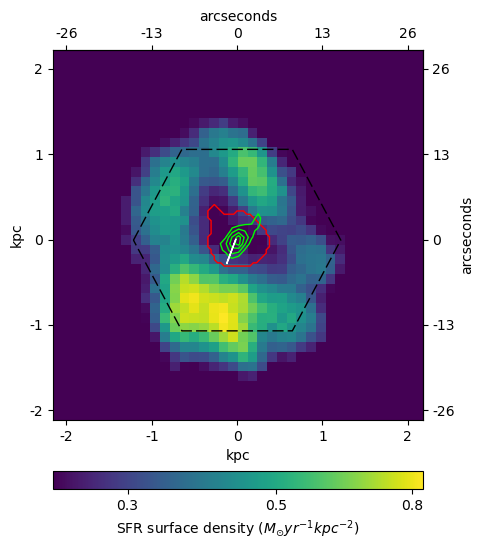

In [10]:
fig, ax = plt.subplots()

std = mad_std(cutout.data, ignore_nan = True)

im = ax.imshow(cutout.data, 
               norm = colors.LogNorm(vmin = np.nanmedian(cutout.data) + 0.9 * std, 
                                    vmax = np.nanmedian(cutout.data) + 6 * std), 
               cmap = 'viridis', 
               origin = "lower")

axins = inset_axes(ax,
                    width="100%",  
                    height="5%",
                    loc='lower center',
                    borderpad=-5
                   )
cbar = fig.colorbar(im, cax = axins, orientation="horizontal",
                    ticks = [0.3, 0.5, 0.8],
                    format = '%.1f', pad =0)

cbar.ax.minorticks_off()
cbar.set_label('SFR surface density ($M_{\odot}yr^{-1}kpc^{-2}$)')

kpc_ticks = np.arange(-2, 3, 1)
ra_positions = centre.spherical_offsets_by(-kpc_ticks / one_arcmin_in_kpc * u.arcmin, -2 / one_arcmin_in_kpc * u.arcmin)  
dec_positions = centre.spherical_offsets_by(2 / one_arcmin_in_kpc * u.arcmin, kpc_ticks / one_arcmin_in_kpc * u.arcmin)  
ra_x_positions = cutout.wcs.world_to_pixel(ra_positions)[0]
dec_y_positions = cutout.wcs.world_to_pixel(dec_positions)[1]

ax.set_xticks(ra_x_positions)
ax.set_yticks(dec_y_positions)
ax.set_xticklabels(kpc_ticks)
ax.set_yticklabels(kpc_ticks)

ax.set_xlabel('kpc')
ax.set_ylabel('kpc')


ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(ra_x_positions)
ax_top.set_xticklabels(np.round(kpc_ticks * 60 / one_arcmin_in_kpc,0).astype('int'))
ax_top.set_xlabel('arcseconds')


ax_right = ax.secondary_yaxis('right')
ax_right.set_yticks(dec_y_positions)
ax_right.set_yticklabels(np.round(kpc_ticks * 60 / one_arcmin_in_kpc,0).astype('int'))
ax_right.set_ylabel('arcseconds')


BPT_contours = Regions.read(contour_reg, format='ds9')
for sky_region in BPT_contours:
    pixel_region = sky_region.to_pixel(cutout.wcs)
    _ = pixel_region.plot(ax=ax)# color='white', lw=0.5)  
    
hexagon_contour = Regions.read(hexagon_reg, format='ds9')    
for sky_region in hexagon_contour:
    pixel_region = sky_region.to_pixel(cutout.wcs)
    _ = pixel_region.plot(ax=ax)
    
VLASS_radio_contour = Regions.read(VLASS_radio_reg, format='ds9')    
for sky_region in VLASS_radio_contour:
    pixel_region = sky_region.to_pixel(cutout.wcs)
    _ = pixel_region.plot(ax=ax)
    
EVN_radio_contour = Regions.read(EVN_radio_reg, format='ds9')    
for sky_region in EVN_radio_contour:
    pixel_region = sky_region.to_pixel(cutout.wcs)
    _ = pixel_region.plot(ax=ax)

fig.savefig('NGC_3982_NUV_image_with_BPT_contours.png',
            format = 'png',
            bbox_inches = 'tight',
            dpi = 300)

In [11]:
# plt.close('all')

In [12]:
# BPT_wcs.world_to_pixel(centre.spherical_offsets_by(square_size  * u.arcmin / 2, square_size * u.arcmin / 2))

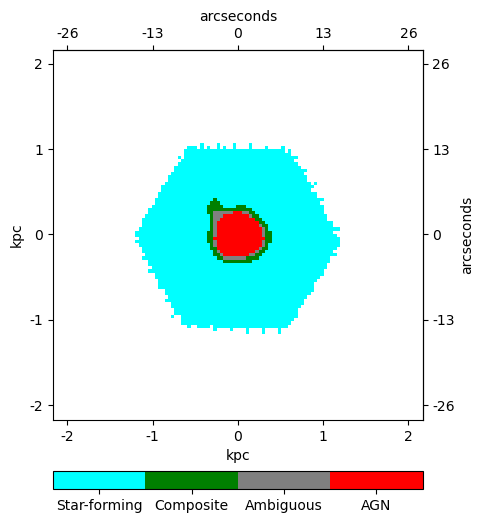

In [13]:
fig, ax = plt.subplots()


#produce colormap with as many colors as there are unique values in df
named_colors = ["white", "cyan", "green", "grey", "red"]  # use hex colors here, if desired.
cmap = colors.ListedColormap(named_colors)

im = ax.imshow(BPT_hdu[0].data, 
               cmap = cmap, 
               origin = "lower")


kpc_ticks = np.arange(-2, 3, 1)
ra_positions = centre.spherical_offsets_by(-kpc_ticks / one_arcmin_in_kpc * u.arcmin, -2 / one_arcmin_in_kpc * u.arcmin)  
dec_positions = centre.spherical_offsets_by(2 / one_arcmin_in_kpc * u.arcmin, kpc_ticks / one_arcmin_in_kpc * u.arcmin)  
ra_x_positions = BPT_wcs.world_to_pixel(ra_positions)[0]
dec_y_positions = BPT_wcs.world_to_pixel(dec_positions)[1]

ax.set_xticks(ra_x_positions)
ax.set_yticks(dec_y_positions)
ax.set_xticklabels(kpc_ticks)
ax.set_yticklabels(kpc_ticks)

ax.set_xlim(-20, 94)
ax.set_ylim(-20, 94)

ax.set_xlabel('kpc')
ax.set_ylabel('kpc')

ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(ra_x_positions)
ax_top.set_xticklabels(np.round(kpc_ticks * 60 / one_arcmin_in_kpc,0).astype('int'))
ax_top.set_xlabel('arcseconds')


ax_right = ax.secondary_yaxis('right')
ax_right.set_yticks(dec_y_positions)
ax_right.set_yticklabels(np.round(kpc_ticks * 60 / one_arcmin_in_kpc,0).astype('int'))
ax_right.set_ylabel('arcseconds')


axins = inset_axes(ax,
                   width = "100%",  
                   height="5%",
                    loc='lower center',
                    borderpad=-5
                   )
cbar = fig.colorbar(im, cax = axins, orientation="horizontal",
                    ticks = [0, 1.2, 2, 2.8, 3.6],
                    pad = 0)

# cbar = fig.colorbar(im,
#                     ticks = [0, 1.2, 2, 2.8, 3.6],
#                     pad =.08)

cbar.ax.set_xticklabels(['', 'Star-forming', 'Composite', 'Ambiguous', 'AGN']) #, fontsize = 8)
cbar.ax.set_xlim(0.8, 4.0)

# SFR_contour = pyregion.open(NUV_SFR_density_reg).as_imagecoord(BPT_hdu[0].header)
# patch_list, artist_list = SFR_contour.get_mpl_patches_texts()
    
# for p in patch_list:
#     ax.add_patch(p)
# for t in artist_list:
#     ax.add_artist(t)
    
fig.savefig('BPT_main_plot.png',
            format = 'png',
            bbox_inches = 'tight',
            dpi = 300)

## Just velocity dispersion figures. 

## OUTFLOW!? [O III] emission line intensity and gas velocity dispersion maps. 

/mnt/160GB_normal/mambaforge/lib/python3.9/site-packages/regions/shapes/polygon.py:181: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Polygon(xy=xy, **mpl_kwargs)


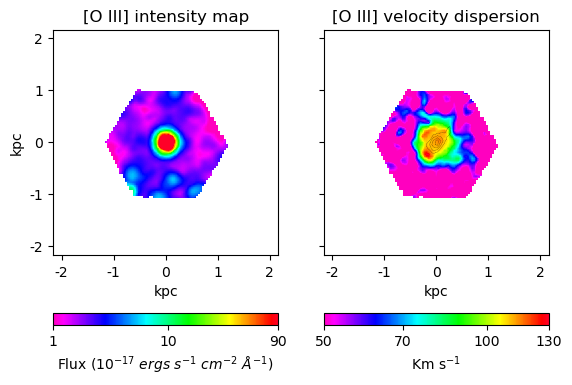

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

im1 = ax1.imshow(oiii_hdu[0].data, cmap = 'gist_rainbow_r', origin = "lower",
                 norm = colors.LogNorm(vmin = 1, vmax = 90))
                 # vmin = 0.2, 
                 # vmax = 1)

ax1.set_title(r'[O III] intensity map')

axins1 = inset_axes(ax1,
                    width="100%",  
                    height="5%",
                    loc='lower center',
                    # bbox_to_anchor=(1.05, 0., 1, 1),
                    # bbox_transform=ax.transAxes,
                    borderpad=-5
                   )
cbar1 = fig.colorbar(im1,cax=axins1, orientation="horizontal", 
                     ticks = [1, 10, 90], 
                     format = '%d', pad =0)

cbar1.ax.minorticks_off()
cbar1.set_label(r'Flux ($10^{-17}\ ergs\ s^{-1}\ cm^{-2}\ \AA^{-1}$)')


im2 = ax2.imshow(oii_gas_disp_hdu[0].data, cmap = 'gist_rainbow_r', origin = "lower",
                 norm = colors.LogNorm(vmin = 50, vmax = 130))
                 # vmin = 15, 
                 # vmax = 60)

ax2.set_title('[O III] velocity dispersion')

# cbar2 = fig.colorbar(im2, ax = ax2, ticks = [10, 20, 40, 80], format = '%d')
# cbar2.set_label(r'Km s$^{-1}$')
# cbar2.ax.minorticks_off()

axins2 = inset_axes(ax2,
                    width="100%",  
                    height="5%",
                    loc='lower center',
                    # bbox_to_anchor=(1.05, 0., 1, 1),
                    # bbox_transform=ax.transAxes,
                    borderpad=-5
                   )
cbar2 = fig.colorbar(im2,cax=axins2, orientation="horizontal", 
                     ticks = [50, 70, 100, 130], 
                     format = '%d', pad =0)

cbar2.ax.minorticks_off()
cbar2.set_label(r'Km s$^{-1}$')


kpc_ticks = np.arange(-2, 3, 1)
centre = SkyCoord(RA_centre * u.deg, DEC_centre * u.deg, frame = 'icrs')
ra_positions = centre.spherical_offsets_by(-kpc_ticks / one_arcmin_in_kpc * u.arcmin, -2 / one_arcmin_in_kpc * u.arcmin)  
dec_positions = centre.spherical_offsets_by(2 / one_arcmin_in_kpc * u.arcmin, kpc_ticks / one_arcmin_in_kpc * u.arcmin)  
ra_x_positions = BPT_wcs.world_to_pixel(ra_positions)[0]
dec_y_positions = BPT_wcs.world_to_pixel(dec_positions)[1]

ax1.set_xticks(ra_x_positions)
ax1.set_yticks(dec_y_positions)
ax1.set_xticklabels(kpc_ticks)
ax1.set_yticklabels(kpc_ticks)

ax1.set_xlim(-20, 94)
ax1.set_ylim(-20, 94)

ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')

ax2.set_xticks(ra_x_positions)
ax2.set_yticks(dec_y_positions)
ax2.set_xticklabels(kpc_ticks)
ax2.set_yticklabels(kpc_ticks)

ax2.set_xlim(-20, 94)
ax2.set_ylim(-20, 94)

ax2.set_xlabel('kpc')

ax2.tick_params('y', which = 'both', labelleft = False) 

# SFR_contour = Regions.read(NUV_SFR_density_reg, format='ds9')
# for sky_region in SFR_contour:
#     pixel_region = sky_region.to_pixel(BPT_wcs)
#     _ = pixel_region.plot(ax=ax1, color='black', lw=0.5)  
#     _ = pixel_region.plot(ax=ax2, color='black', lw=0.5)  

VLASS_contour = Regions.read(VLASS_radio_reg, format='ds9')
for sky_region in VLASS_contour:
    pixel_region = sky_region.to_pixel(BPT_wcs)
    _ = pixel_region.plot(ax=ax2, color='black', lw=0.2, ls = '--')  

# SFR_contour = pyregion.open(NUV_SFR_density_reg).as_imagecoord(BPT_hdu[0].header)    
# patch_list, artist_list = SFR_contour.get_mpl_patches_texts() 
    
# for p in patch_list:
#     ax1.add_patch(p)
# for t in artist_list:
#     ax1.add_artist(t)

# patch_list, artist_list = SFR_contour.get_mpl_patches_texts()


# for p in patch_list:
#     ax2.add_patch(p)
# for t in artist_list:
#     ax2.add_artist(t)
    
    
fig.savefig('oiii_intensity_and_dispersion.png',
            format = 'png',
            bbox_inches = 'tight',
            dpi = 300)

In [18]:
plt.close('all')

## [O III] / H$_{\beta}$ and gas velocity dispersion maps. 

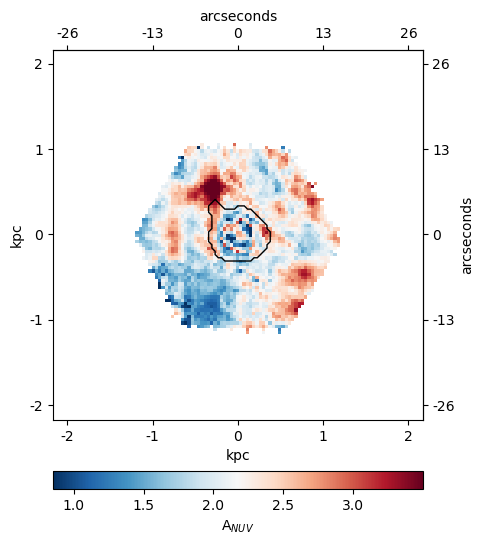

In [21]:
fig, ax = plt.subplots()

im = ax.imshow(A_NUV_hdu[0].data, 
               cmap = 'RdBu_r', 
               origin = "lower",
               vmin = 0.85, 
               vmax = 3.5)


kpc_ticks = np.arange(-2, 3, 1)
ra_positions = centre.spherical_offsets_by(-kpc_ticks / one_arcmin_in_kpc * u.arcmin, -2 / one_arcmin_in_kpc * u.arcmin)  
dec_positions = centre.spherical_offsets_by(2 / one_arcmin_in_kpc * u.arcmin, kpc_ticks / one_arcmin_in_kpc * u.arcmin)  
ra_x_positions = BPT_wcs.world_to_pixel(ra_positions)[0]
dec_y_positions = BPT_wcs.world_to_pixel(dec_positions)[1]

ax.set_xticks(ra_x_positions)
ax.set_yticks(dec_y_positions)
ax.set_xticklabels(kpc_ticks)
ax.set_yticklabels(kpc_ticks)

ax.set_xlim(-20, 94)
ax.set_ylim(-20, 94)

ax.set_xlabel('kpc')
ax.set_ylabel('kpc')

ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(ra_x_positions)
ax_top.set_xticklabels(np.round(kpc_ticks * 60 / one_arcmin_in_kpc,0).astype('int'))
ax_top.set_xlabel('arcseconds')


ax_right = ax.secondary_yaxis('right')
ax_right.set_yticks(dec_y_positions)
ax_right.set_yticklabels(np.round(kpc_ticks * 60 / one_arcmin_in_kpc,0).astype('int'))
ax_right.set_ylabel('arcseconds')

axins = inset_axes(ax,
                    width="100%",  
                    height="5%",
                    loc='lower center',
                    borderpad=-5
                   )
cbar = fig.colorbar(im, cax = axins, orientation = "horizontal",
                    ticks = [1, 1.5, 2, 2.5, 3],
                    pad = 0)

cbar.set_label(r'A$_{NUV}$')

BPT_contour_color = pyregion.open("bpt_contours_black.reg").as_imagecoord(BPT_hdu[0].header)
patch_list, artist_list = BPT_contour_color.get_mpl_patches_texts() 
    
for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)
    
fig.savefig('A_NUV.png',
            format = 'png',
            bbox_inches = 'tight',
            dpi = 300)